In [5]:
import os
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)

In [35]:
def combine_temps(df, temp_target='TN', quality='Q_TN'):
    df.columns = df.columns.str.strip()
    df['DateTime'] = df['DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    df['JD'] = df['DateTime'].dt.dayofyear
    mt = df[df[quality] == 0]
    mt['temp'] = mt[temp_target]*.1
    return pd.DataFrame(mt.groupby('JD')['temp'].mean()).reset_index()

In [36]:
min_temps = pd.read_csv('./data/ECA_blended_custom_min/TN_STAID000212.txt',skiprows=range(18), sep=',')
min_temps = combine_temps(min_temps, temp_target='TN', quality='Q_TN')

max_temps = pd.read_csv('./data/ECA_blended_custom_max/TX_STAID000212.txt',skiprows=range(18), sep=',')
max_temps = combine_temps(max_temps, temp_target='TX', quality='Q_TX')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


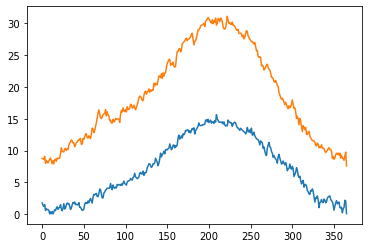

In [37]:
plt.plot(min_temps['temp'])
plt.plot(max_temps['temp'])